# FAKE NEWS DETECTION

# Fake News
The authenticity of Information has become a longstanding issue affecting businesses and society, both for printed and digital media. On social networks, the reach and effects of information spread occur at such a fast pace and so amplified that distorted, inaccurate or false information acquires a tremendous potential to cause real world impacts, within minutes, for millions of users.

### LOADING THE NECCESSARY LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re, string, unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [2]:
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')

In [3]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
true['category'] = 1
fake['category'] = 0
df = pd.concat([true, fake], axis = 0)

In [6]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


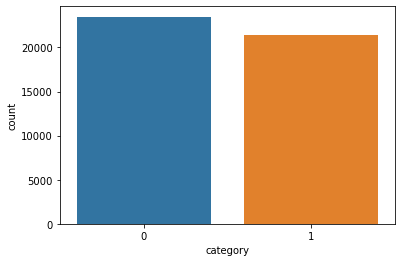

In [7]:
# Checking for a Balanced Dataset
ax = sns.countplot(x = 'category', data = df)

#### THE DATA SEEMS BALANCED. 

In [8]:
# Checking for nan values
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

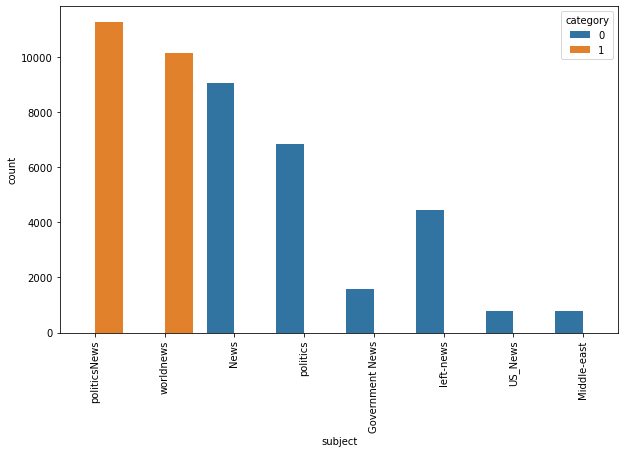

In [9]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x = 'subject', hue = 'category', data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

#### THE ABOVE PLOT INDICATES THAT THE 'subject' COLUMN CREATES A DATA LEAKAGE PROBLEM. WE REMOVE THIS COLUMN TO PREVENT BIASED PREDICTIONS.

In [10]:
df['text'] = df['title'] + " " + df['text']

del df['title'], df['subject'], df['date']

In [11]:
df.head()

,text,category
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


### TEXT PREPROCESSING

In [12]:
unwanted = set(stopwords.words('english'))
punc = list(string.punctuation)
unwanted.update(punc)

def denoise_text(text):
    temp = BeautifulSoup(text, 'html.parser')
    text = temp.get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(r'https\S+', '', text)
    final = []
    for i in text.split():
        if i.strip().lower() not in unwanted:
            final.append(i.strip())
    return " ".join(final)

df['text'] = df['text'].apply(denoise_text)

### OBTAIN CORPUS OF WORDS FROM THE TEXT

In [13]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df['text'])

### DATA SPLIT INTO TRAINING AND TEST SETS

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['category'], random_state = 50)
max_features = 10000
maxlen = 300

### WE APPLY THE TOKENIZER(KERAS) TO THE TRAINING DATA. USE IT TO TOKENIZE THE TRAINING AND TEST SETS. THEN, PAD THE SEQUENCES TO 'maxlen'

In [15]:
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

### PRE-TRAINED GLOVE EMBEDDINGS :

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Here, we use pre-trained word embeddings built on a much larger training data. The GloVe database contains multiple pre-trained word embeddings, and more specific embeddings trained on tweets.

In [16]:
embedding = '/kaggle/input/glove-global-vectors-for-word-representation/glove.twitter.27B.100d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding))

In [17]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


### USING 'ReduceLRONPlateau' TO REDUCE LEARING RATE IF VALIDATION ACCURACY DOESN'T IMPROVE TWO TIMES CONSECUTIVELY

In [18]:
batch_size = 256
epochs = 10
embed_size = 100
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

### MODEL DEFINITON

In [19]:
# Defining Neural Network
model = Sequential()
# Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim = embed_size, weights= [embedding_matrix], input_length = maxlen, trainable = False))
# LSTM 
model.add(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.25, dropout = 0.25))
model.add(LSTM(units = 64, recurrent_dropout = 0.1, dropout = 0.1))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy']) 

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    validation_data = (X_test, y_test),
                    epochs = epochs,
                    callbacks = [lr_reduction])

Epoch 1/10
132/132 [==============================] - 303s 2s/step - loss: 0.1682 - accuracy: 0.9305 - val_loss: 0.0341 - val_accuracy: 0.9885 - lr: 0.0100
Epoch 2/10
132/132 [==============================] - 305s 2s/step - loss: 0.0364 - accuracy: 0.9882 - val_loss: 0.0220 - val_accuracy: 0.9928 - lr: 0.0100
Epoch 3/10
132/132 [==============================] - 303s 2s/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.0124 - val_accuracy: 0.9955 - lr: 0.0100
Epoch 4/10
132/132 [==============================] - 302s 2s/step - loss: 0.0226 - accuracy: 0.9929 - val_loss: 0.0117 - val_accuracy: 0.9967 - lr: 0.0100
Epoch 5/10
132/132 [==============================] - 301s 2s/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0293 - val_accuracy: 0.9898 - lr: 0.0100
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9948
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
132/132 [==============================] - 30

### TRAINING CURVE

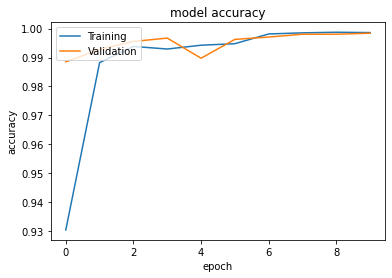

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.show()